In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import cv2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn import svm
from sklearn.metrics import  f1_score, precision_score, recall_score, accuracy_score
import os
import shutil
import random
import numpy as np
from skimage.io import imread, imshow
from keras.utils import img_to_array, load_img
from sklearn.model_selection import train_test_split
from keras.layers import concatenate, Activation, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, Input
from keras.optimizers import Adam
from keras.models import Model
import tensorflow as tf
from skimage.transform import resize
from skimage import io, color, feature, img_as_ubyte, measure

tf.config.run_functions_eagerly(True)


## Read Metadata file and copy data to train/ test folders

In [7]:
df_metadata = pd.read_csv('data/HAM10000_metadata')
train_data, test_data = train_test_split(df_metadata, train_size=0.75, random_state=7, stratify=df_metadata.dx)


In [11]:
# fetch the values of only the "image_id" column form the dataframe and create a list of image names
train_list = train_data['image_id'].values.tolist()
test_list = test_data['image_id'].values.tolist()

# append .jpg and _segmentation.png values to create the image list and the segmentation mask list
train_img_list = [image+'.jpg' for image in train_list]
test_img_list = [image+'.jpg' for image in test_list]
train_seg_list = [image+'_segmentation.png' for image in train_list]
test_seg_list = [image+'_segmentation.png' for image in test_list]


In [160]:
# Copy the masks in the test list to the data/test/masks folder
mask_source_folder = 'HAM10000_segmentations_lesion_tschandl/HAM10000_segmentations_lesion_tschandl'
mask_destination_folder = 'data/test/masks'

for image in test_seg_list:
    shutil.copy(os.path.join(mask_source_folder, image), mask_destination_folder)
    
# Copy the test images in data/HAM10000 folder to the test folder
img_source_folder = 'data/HAM10000'
img_destination_folder = 'data/test'

for image in test_img_list:
    shutil.copy(os.path.join(img_source_folder, image), img_destination_folder)

In [163]:
# Copy the masks in the train list to the data/train/masks folder
mask_source_folder = 'HAM10000_segmentations_lesion_tschandl/HAM10000_segmentations_lesion_tschandl'
mask_destination_folder = 'data/train/masks'

for image in train_seg_list:
    shutil.copy(os.path.join(mask_source_folder, image), mask_destination_folder)

# Copy the train images in data/HAM10000 folder to the train folder
img_source_folder = 'data/HAM10000'
img_destination_folder = 'data/train'

for image in train_img_list:
    shutil.copy(os.path.join(img_source_folder, image), img_destination_folder)

## Create Train, Test data for Image Segmentation

In [15]:
IMAGE_WIDTH = 384
IMAGE_HEIGHT = 256
IMAGE_CHANNELS = 3

In [16]:
DATA_PATH = 'data/train'
MASK_PATH = 'data/train/masks'

X = np.zeros((len(train_img_list[:2000]),IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
Y = np.zeros((len(train_seg_list[:2000]),IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype = bool)

for n, img_name in enumerate(train_img_list[:2000]):
    path = DATA_PATH +'\\'+img_name
    img = imread(path)[:,:,:IMAGE_CHANNELS] 
    img_resize = resize(img, (IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNELS), mode = 'constant', preserve_range = True)
    X[n] = img_resize
    
for n, img_name in enumerate(train_seg_list[:2000]):
    path = MASK_PATH +'\\'+img_name
    mask = img_to_array(load_img(path, color_mode = 'grayscale'))
    mask_resize = resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH, 1), mode = 'constant', preserve_range = True)
    Y[n] = mask_resize

In [20]:
# Perform a train, validation split from the initial train split data for training the segmentation model
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train_tags, X_valid_tags, y_train_tags, y_valid_tags = train_test_split(train_img_list[:2000], train_seg_list[:2000], test_size=0.2, random_state=42)

In [35]:
TEST_DATA_PATH = 'data/test'
TEST_MASK_PATH = 'data/test/masks'

X_test = np.zeros((len(test_img_list[:400]),IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_seg_list[:400]),IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype = bool)

for n, img_name in enumerate(test_img_list[:400]):
    path = TEST_DATA_PATH +'\\'+img_name
    img = imread(path)[:,:,:IMAGE_CHANNELS] 
    img_resize = resize(img, (IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNELS), mode = 'constant', preserve_range = True)
    X_test[n] = img_resize

for n, img_name in enumerate(test_seg_list[:400]):
    path = TEST_MASK_PATH +'\\'+img_name
    mask = img_to_array(load_img(path, color_mode = 'grayscale'))
    mask_resize = resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH, 1), mode = 'constant', preserve_range = True)
    Y_test[n] = mask_resize
    

## Visualize the X_train and y_train data

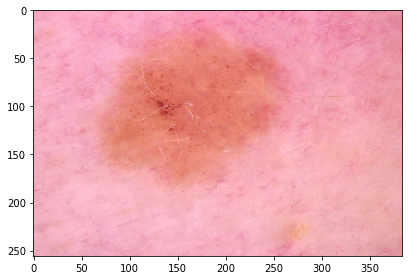

In [24]:
index = random.randint(0, len(X_train))
imshow(X_train[index])

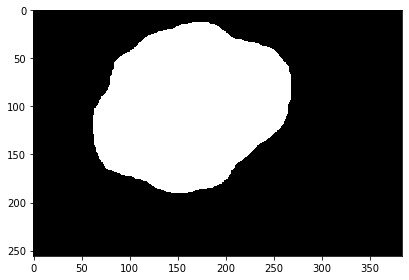

In [25]:
imshow(np.squeeze(y_train[index].astype(np.float32)))

In [27]:
print(X_train_tags[index], y_train_tags[index] )

ISIC_0026460.jpg ISIC_0026460_segmentation.png


## Define the UNET Model for Image Segmentation

In [31]:
def get_conv2d_layers(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to create convolution layers with the given input parameters"""
    # Layer 1
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Layer 2
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # UNET Contracting path
    conv1 = get_conv2d_layers(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(dropout)(pool1)
    
    conv2 = get_conv2d_layers(pool1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(dropout)(pool2)
    
    conv3 = get_conv2d_layers(pool2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(dropout)(pool3)
    
    conv4 = get_conv2d_layers(pool3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout)(pool4)
    
    conv5 = get_conv2d_layers(pool4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # UNET Expansive path
    up6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(conv5)
    up6 = concatenate([up6, conv4])
    up6 = Dropout(dropout)(up6)
    conv6 = get_conv2d_layers(up6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    up7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(conv6)
    up7 = concatenate([up7, conv3])
    up7 = Dropout(dropout)(up7)
    conv7 = get_conv2d_layers(up7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    up8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(conv7)
    up8 = concatenate([up8, conv2])
    up8 = Dropout(dropout)(up8)
    conv8 = get_conv2d_layers(up8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    up9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(conv8)
    up9 = concatenate([up9, conv1])
    up9 = Dropout(dropout)(up9)
    conv9 = get_conv2d_layers(up9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [32]:
# intialize the model and compile it with giving as inputs the optimizer type, loss function and metrics type
image_dims = Input((IMAGE_HEIGHT,IMAGE_WIDTH, IMAGE_CHANNELS), name='img')
model = unet(image_dims, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [33]:
# view the summary of the created UNET model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 256, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_17 (Conv2D)             (None, 256, 384, 16  448         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_17 (BatchN  (None, 256, 384, 16  64         ['conv2d_17[0][0]']              
 ormalization)                  )                                                             

 concatenate_1 (Concatenate)    (None, 64, 96, 128)  0           ['conv2d_transpose_1[0][0]',     
                                                                  'activation_21[0][0]']          
                                                                                                  
 dropout_13 (Dropout)           (None, 64, 96, 128)  0           ['concatenate_1[0][0]']          
                                                                                                  
 conv2d_29 (Conv2D)             (None, 64, 96, 64)   73792       ['dropout_13[0][0]']             
                                                                                                  
 batch_normalization_29 (BatchN  (None, 64, 96, 64)  256         ['conv2d_29[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

In [34]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-skin-lesion-segmentation-org2000.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

## Train the UNET Model

In [205]:
# Below is the code to train the defined UNET model for 10 epochs with a batch size of 32.
# The training has been stopped at epoch 8 as there is no further improvement in the validation loss post epoch 5
results = model.fit(X_train, y_train, batch_size=32, epochs=10, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

C:\Users\mslme\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
50/50 [==============================] - ETA: 0s - loss: 0.4143 - accuracy: 0.8355 
Epoch 1: val_loss improved from inf to 9.10726, saving model to model-skin-lesion-segmentation-org2000.h5
50/50 [==============================] - 1361s 27s/step - loss: 0.4143 - accuracy: 0.8355 - val_loss: 9.1073 - val_accuracy: 0.4878 - lr: 0.0010
Epoch 2/10
50/50 [==============================] - ETA: 0s - loss: 0.2937 - accuracy: 0.8914 
Epoch 2: val_loss improved from 9.10726 to 0.55967, saving model to model-skin-lesion-segmentation-org2000.h5
50/50 [==============================] - 1121s 22s/step - loss: 0.2937 - accuracy: 0.8914 - val_loss: 0.5597 - val_accuracy: 0.8239 - lr: 0.0010
Epoch 3/10
50/50 [==============================] - ETA: 0s - loss: 0.2493 - accuracy: 0.9072 
Epoch 3: val_loss improved from 0.55967 to 0.48105, saving model to model-skin-lesion-segmentation-org2000.h5
50/50 [==============================] - 899s 18s/step - loss: 0.2493 - accuracy: 0.9072 - val_loss

KeyboardInterrupt: 

In [38]:
# Once the model training has been done, from next time onwards we can just load the model weights instead of retraining the model
model.load_weights('model-skin-lesion-segmentation-org2000.h5')

In [39]:
model.evaluate(X_test, Y_test, verbose=1)

C:\Users\mslme\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


13/13 [==============================] - 63s 5s/step - loss: 0.2476 - accuracy: 0.9120


[0.24757148325443268, 0.9119883179664612]

In [40]:
predicted = model.predict(X_test, verbose=1)
predicted = (predicted > 0.5).astype(bool)

13/13 [==============================] - 58s 4s/step


## Plot the predicted UNET Masks

In [50]:
def plot_masks(X_test, Y_test, predicted, idx=None):
    """Function to visualize the masks predicted by the UNET model"""

    figure, ax = plt.subplots(1, 3, figsize=(20, 10))
    if idx is None:
        idx = random.randint(0, len(X_test))

    ax[0].imshow(X_test[idx])
    ax[0].contour(np.squeeze(predicted[idx]))
    ax[0].set_title('Original Image')

    ax[1].imshow(Y_test[idx].squeeze())
    ax[1].set_title('Ground Truth Mask')

    ax[2].imshow(predicted[idx].squeeze())
    ax[2].set_title('UNET Predicted Mask')
    

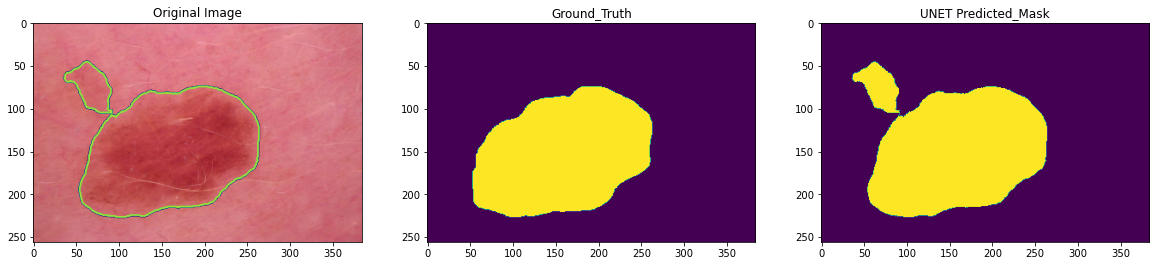

In [49]:
plot_masks(X_test, Y_test, predicted, idx= 190)

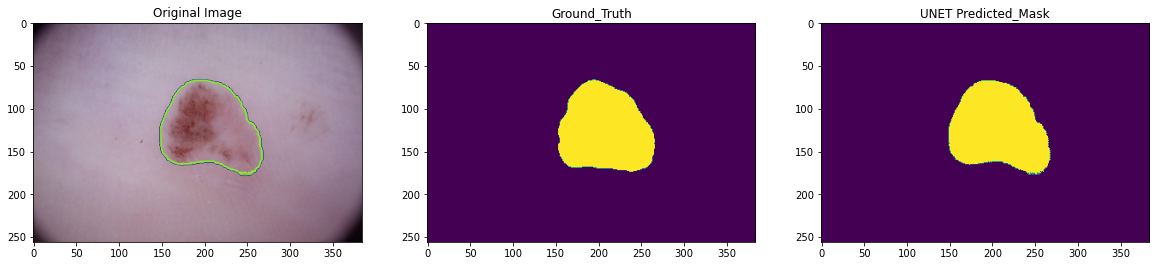

In [46]:
plot_masks(X_test, Y_test, predicted, idx= 120)

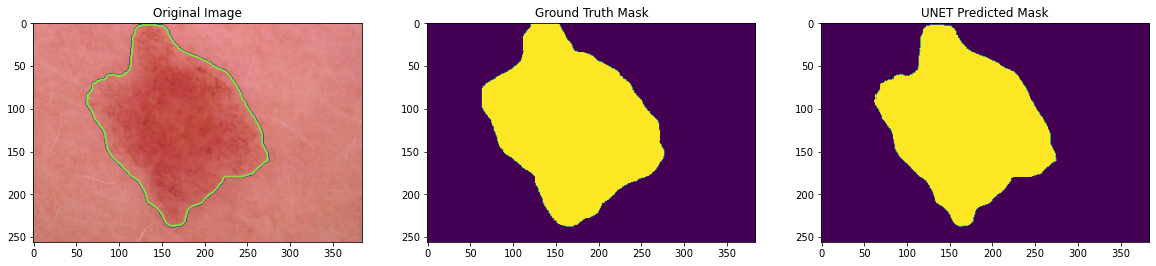

In [53]:
plot_masks(X_test, Y_test, predicted, idx= 15)

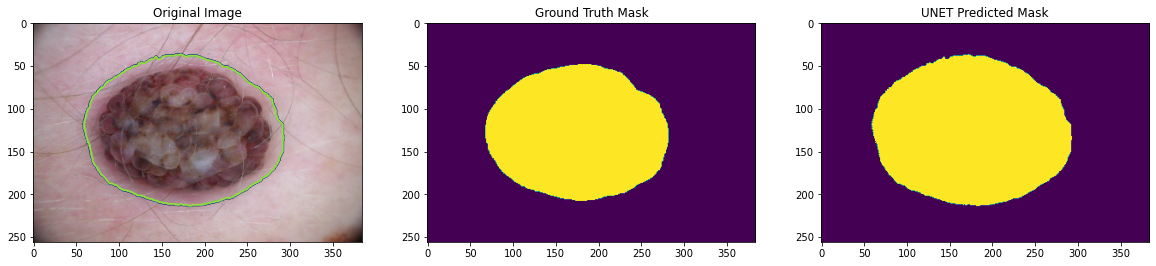

In [54]:
plot_masks(X_test, Y_test, predicted, idx= 33)

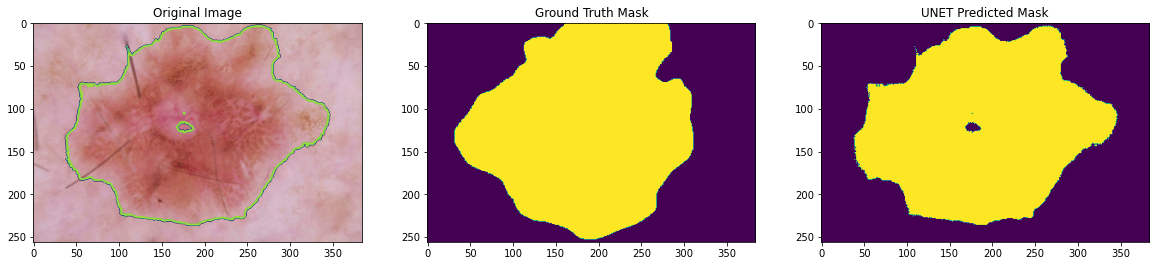

In [56]:
plot_masks(X_test, Y_test, predicted, idx= 351)

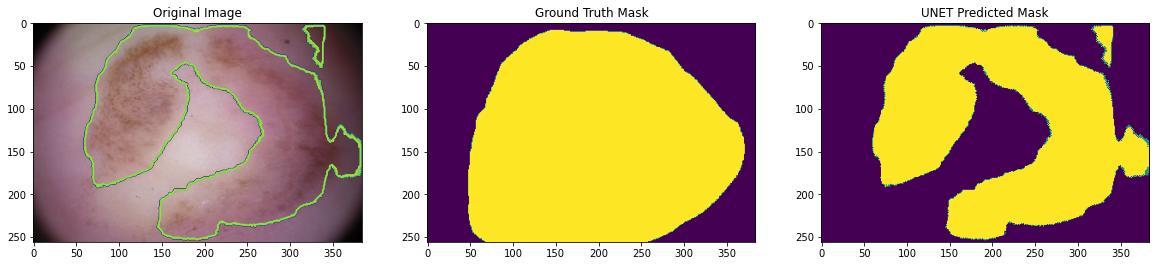

In [57]:
plot_masks(X_test, Y_test, predicted, idx= 350)

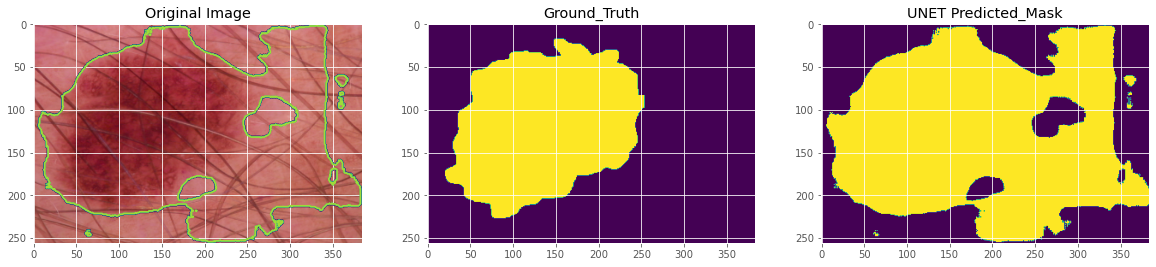

In [356]:
plot_masks(X_test, Y_test, predicted, idx= 4)
# We see that the trained model does not perform very well when there's lot of noise in the 
# image (hair, gel blobs, water droplets) so, we later on perform preprocessing on images before sending them to our model.

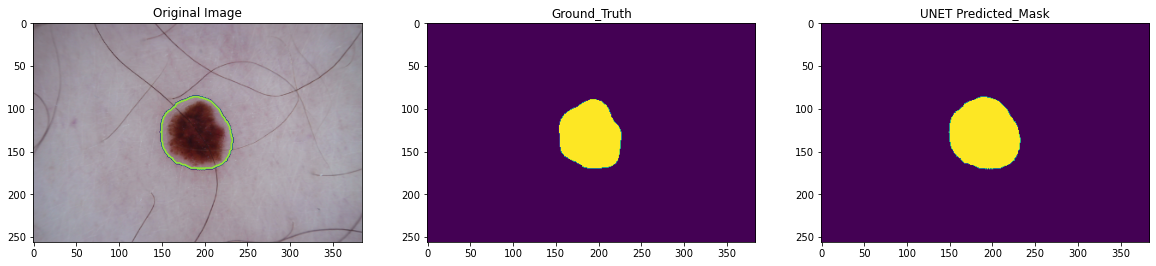

In [43]:
plot_masks(X_test, Y_test, predicted, idx= 0)

## Extract Features from Segmentation Masks to perform Tumor classification

### Create Train, Test data for Image classification

In [74]:
# From the segmentation masks in the test data create the test data for classification
test_dict = {}
for i in range(Y_test.shape[0]):
    img_label = measure.label(np.squeeze(Y_test[i])) 
    region_props = measure.regionprops(img_label)
    num_labels = len(region_props)
    areas = [region.area for region in region_props]
    if num_labels > 0 and areas[np.argmax(areas)] >= 1200:
        target_label = region_props[np.argmax(areas)].label
        test_dict[test_img_list[i]] = region_props[target_label -1]


In [75]:
# From the segmentation masks in the train data create the train data for classification
train_dict = {}
for i in range(y_train.shape[0]):
    img_label_train = measure.label(np.squeeze(y_train[i])) 
    props_train = measure.regionprops(img_label_train)
    num_labels = len(props_train)
    areas = [region.area for region in props_train]
    if num_labels > 0 and areas[np.argmax(areas)] >= 1200:
        target_label = props_train[np.argmax(areas)].label
        train_dict[X_train_tags[i]] = props_train[target_label -1]

In [80]:
len(train_dict)

1597

In [81]:
len(test_dict)

397

### Define Function to extract the ABCDT features from the segmentation masks

In [82]:
# function code referenced from https://github.com/biagiom/skin-lesions-classifier/blob/master/skin_lesions_classifier.ipynb
def extract_features(input_dict, base_path):
    """Function to perform feature extraction for the segmented masks by calculating their Asymmetry, Border irregularity,
    Color variation, Diameter and Texture"""
    features = {}
    for idx, image_name in enumerate(input_dict):
        path = base_path+'\\'+image_name
        image = imread(path)
        gray_img = color.rgb2gray(image)
        lesion_region = input_dict[image_name]

        # Asymmetry
        area_total = lesion_region.area
        img_mask = lesion_region.image
        horizontal_flip = np.fliplr(img_mask)
        diff_horizontal = img_mask * ~horizontal_flip
        vertical_flip = np.flipud(img_mask)
        diff_vertical = img_mask * ~vertical_flip
        diff_horizontal_area = np.count_nonzero(diff_horizontal)
        diff_vertical_area = np.count_nonzero(diff_vertical)
        asymm_idx = 0.5 * ((diff_horizontal_area / area_total) + (diff_vertical_area / area_total))
        ecc = lesion_region.eccentricity

        # Border irregularity
        compact_index = (lesion_region.perimeter ** 2) / (4 * np.pi * area_total)


        # Color variegation:
        sliced = image[lesion_region.slice]
        lesion_r = sliced[:, :, 0]
        lesion_g = sliced[:, :, 1]
        lesion_b = sliced[:, :, 2]
        C_r = np.std(lesion_r) / np.max(lesion_r)
        C_g = np.std(lesion_g) / np.max(lesion_g)
        C_b = np.std(lesion_b) / np.max(lesion_b)

        # Diameter:
        eq_diameter = lesion_region.equivalent_diameter


        # Texture:
        glcm = feature.greycomatrix(image=img_as_ubyte(gray_img), distances=[1],
                                    angles=[0, np.pi/4, np.pi/2, np.pi * 3/2],
                                    symmetric=True, normed=True)
        correlation = np.mean(feature.greycoprops(glcm, prop='correlation'))
        homogeneity = np.mean(feature.greycoprops(glcm, prop='homogeneity'))
        energy = np.mean(feature.greycoprops(glcm, prop='energy'))
        contrast = np.mean(feature.greycoprops(glcm, prop='contrast'))

        features[image_name] = [asymm_idx, ecc, compact_index, C_r, C_g, C_b,
                                       eq_diameter, correlation, homogeneity, energy, contrast]
    return features

In [83]:
# Invoke the extract_features function to calculate the ABCDT properties for train, test data
train_features = extract_features(train_dict, 'data/train')
test_features = extract_features(test_dict, 'data/test')

In [86]:
for i in range(df_metadata['image_id'].count()):
    df_metadata.at[i, 'image_id'] += '.jpg'
    
# fetch the target variable 'dx' for the train, test data
test_df = df_metadata.loc[df_metadata['image_id'].isin(list(test_features.keys()))]
train_df = df_metadata.loc[df_metadata['image_id'].isin(list(train_features.keys()))]

In [87]:
train_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419.jpg,bkl,histo,80.0,male,scalp,vidir_modern
9,HAM_0005132,ISIC_0025209.jpg,bkl,histo,70.0,female,back,vidir_modern
14,HAM_0001949,ISIC_0032417.jpg,bkl,histo,70.0,male,trunk,vidir_modern
15,HAM_0007207,ISIC_0031326.jpg,bkl,histo,65.0,male,back,vidir_modern
21,HAM_0003301,ISIC_0025033.jpg,bkl,histo,60.0,male,back,vidir_modern
...,...,...,...,...,...,...,...,...
9983,HAM_0006252,ISIC_0026040.jpg,akiec,histo,70.0,female,face,rosendahl
9989,HAM_0004384,ISIC_0029025.jpg,akiec,histo,70.0,male,face,rosendahl
9999,HAM_0000356,ISIC_0030655.jpg,akiec,histo,60.0,female,face,rosendahl
10004,HAM_0005579,ISIC_0029309.jpg,akiec,histo,80.0,male,face,rosendahl


In [89]:
# Convert values to list
X_train_svm = list(train_features.values())
y_train_svm = train_df['dx'].values.tolist()

X_test_svm = list(test_features.values())
y_test_svm = test_df['dx'].values.tolist()

In [94]:
# Convert the cancer classes in target variable as cancerous or non-cancerous
for i in range(len(y_train_svm)):
    if y_train_svm[i] in ['bkl','df','nv','vasc']:
        y_train_svm[i] = 'benign'
    else:
        y_train_svm[i] = 'cancerous'
        
for i in range(len(y_test_svm)):
    if y_test_svm[i] in ['bkl','df','nv','vasc']:
        y_test_svm[i] = 'benign'
    else:
        y_test_svm[i] = 'cancerous'

### Train SVM Model to perform Cancer Classification

In [119]:
# Train the SVM polynomial kernel to perform classification on our dataset
clf = svm.SVC(gamma=0.001, kernel='poly', degree=5)
clf = clf.fit(X_train_svm, y_train_svm)

y_pred = clf.predict(X_test_svm)

In [103]:
# save the SVM classification model to .pkl file for later use
with open('svm_model_poly.pkl', 'wb') as file:
    pickle.dump(clf, file)

### SVM Performance metrics

In [125]:
# Calculate the performance metrics of the SVM Classifier
accuracy = accuracy_score(y_test_svm, y_pred)
f1 = f1_score(y_test_svm, y_pred, average='weighted')
recall = recall_score(y_test_svm, y_pred, average='weighted')
precision = precision_score(y_test_svm, y_pred, average='weighted')

print('Accuracy: {:.3f}'.format(accuracy))
print('F1-score: {:.3f}'.format(f1))
print('Recall: {:.3f}'.format(recall))
print('Precision: {:.3f}'.format(precision))

Accuracy: 0.804
F1-score: 0.716
Recall: 0.804
Precision: 0.646


C:\Users\mslme\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Function to Pre-Process images to be used for segmentation

In [50]:
# The steps in the below function are being used to perform image pre-processing using the PyQT terminal
def pre_process_images():
    """Function to perform removal of hair in images by using the dull razor method"""
    
    image_path = 'data/test'
    abs_path = os.path.abspath('data/test/preprocessed')

    for img_name in test_image_ids[:20]:
        full_path = os.path.join(image_path, img_name)
        preprocess_path = os.path.join(abs_path, img_name)

        image = io.imread(full_path)
        # Convert the image to grayscale
        grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Define kernel to perform Morphological operations
        kernel = cv2.getStructuringElement(1, (17, 17))

        # Filter the grayscale image using Blackhat filtering technique to find the hair contours
        blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)

        # Increase the intensity of the hair contours to perform inpainting of the image
        ret, thresh2 = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)

        # Perform inpainting of the original image using the thresholds calculated above
        dst = cv2.inpaint(image, thresh2, 1, cv2.INPAINT_TELEA)
        img_filtered = cv2.GaussianBlur(dst,(7,7),0)
        io.imsave(preprocess_path, img_filtered)

In [ ]:
pre_process_images()